<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/RNA_Workshop/BMX_Ingest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scanpy --quiet
!pip install pybiomart --quiet
!pip install python-igraph --quiet
!pip install louvain --quiet
!pip install pynndescent --quiet




import h5py
import numpy as np
import scipy as sci
from matplotlib import pyplot as plt
import scanpy as sc
import tarfile
import os
import anndata as ad
import pandas as pd
import pybiomart
import shutil
from tqdm import tqdm
import urllib.request
from IPython.display import clear_output
from matplotlib.pyplot import rc_context
from scipy import stats as st
import logging
logger = logging.basicConfig(level=logging.INFO,format='%(asctime)s  %(message)s', datefmt='%Y/%m/%d %I:%M:%S %p',force=True)



In [3]:
def z_score(x,axis=-1):
    x=np.array(x)
    return (x-np.mean(x,axis=axis))/np.std(x,axis=axis)


def publishable_plots(FS=6):
    plt.rcParams.update({'font.size': FS,'axes.linewidth':.5,'figure.dpi':300,
                         'xtick.major.width': 0.5,'ytick.major.width': 0.5,
                         'figure.titlesize':FS,'axes.titlesize': FS,'xtick.labelsize': FS,
                         'ytick.labelsize':FS,'axes.labelsize': FS,'legend.fontsize': FS,
                         'figure.labelsize':FS})

    import urllib.request
    arial_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Fonts/arial.ttf'
    filename = './arial.ttf'
    urllib.request.urlretrieve(arial_link, filename)
    plt.rcParams.update({'font.family': 'arial'})
    return None



def pull_gene_annots(csv_loc='./mmusculus_coding_noncoding.csv',
                     my_git='https://raw.githubusercontent.com/dtabuena/Resources/main/Genetics/mmusculus_coding_noncoding.csv',
                     biomart_name='mmusculus',
                     biomart_keys=["ensembl_gene_id", "chromosome_name","transcript_biotype","external_gene_name","peptide"]):

    logging.info('pulling gene annotations...')
    if os.path.exists('./mmusculus_coding_noncoding.csv'):
        logging.info( 'Use local copy of musmus')
        annot_dd = pd.read_csv('./mmusculus_coding_noncoding.csv').set_index("external_gene_name")
    else:
        try:
            logging.info( 'attempting to pull mus mus from git...')
            musmus_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Genetics/mmusculus_coding_noncoding.csv'
            filename = './mmusculus_coding_noncoding.csv'
            urllib.request.urlretrieve(musmus_link, filename)
            annot_dd = pd.read_csv(filename).set_index("external_gene_name")
        except:
            logging.info('attempting to pull mus mus from biomart...')
            annot = sc.queries.biomart_annotations("mmusculus",["ensembl_gene_id", "chromosome_name","transcript_biotype","external_gene_name"],).set_index('ensembl_gene_id')
            uniq_inds = list(set(list(annot.index)))
            for r in tqdm(uniq_inds):
                match_bool = annot.index.str.contains(r)
                if np.sum(match_bool)>1:
                    new_val ='__'.join(list(annot.loc[r,'transcript_biotype']))
                    annot.at[r,'transcript_biotype']=new_val
            annot['is_coding']= annot.transcript_biotype.str.contains('coding')
            annot_dd = annot.drop_duplicates().set_index("external_gene_name")
            annot_dd.to_csv('./mmusculus_coding_noncoding.csv')

    coding_list = annot_dd.index[ annot_dd['is_coding'] ].to_list()
    return coding_list, annot_dd

publishable_plots(6)
sc.settings.verbosity = 'error'             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, facecolor='white',fontsize=6,figsize=(1.5,1.5))
pd.set_option('display.max_rows',100)

In [4]:

def trim_key(k):
    floxed_dict = {'GSM5106175_YH_KZ03_01':('E3fKI_Syn_Cre602_15m','GSM5106175_602_E3fKI_15_XX'),
                   'GSM5106176_YH_KZ03_03':('E4fKI_Syn_Cre475_15m','GSM5106176_475_E4fKI_15_XX')}
    for f in floxed_dict.keys():
        if f in k: return floxed_dict[f][1]
    k = k.replace('_raw_gene_bc_matrices_h5.h5',"")
    return k

def high_var_genes_dim_reduc(adata,min_mean = 0.25,max_mean = 4,min_disp=0.55,pca_list=[],to_plot=True):
    ''' The gene expression matrices were then log-normalized with a scale factor of 10,000,
    using the Seurat NormalizeData function57,58. Highly dispersed genes were selected using
    the Seurat FindVariableGenes function57,58,filtering for an average expression range of
    0.25–4 and a minimum dispersion of 0.55, resulting in a list of 2,197 genes.'''
    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=10000)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
    with rc_context({'figure.figsize': (1.5, 1.5)}):
        sc.pl.highly_variable_genes(adata)
    plt.tight_layout()
    num_hv =  str(np.sum(adata.var['highly_variable']))
    logging.info(f'{num_hv} hv genes')


    #### PCA
    sc.tl.pca(adata, svd_solver='arpack',n_comps=100)
    if to_plot and len(pca_list)>0:
        fig,ax=plt.subplots(figsize=(1.5,1))
        ax.plot(adata.uns['pca']['variance_ratio'][:35],'ok',markersize=1)
        quiet_PCA_plots(adata,pca_list,pc_pairs=[(0,1),(2,3),(4,5),(6,7)])

    return adata

def quiet_PCA_plots(adata,key_list,figsize=(1.5, 1.5),pc_pairs=[(0,1)]):
    fig,ax=plt.subplots(1*len(pc_pairs),len(key_list),figsize=(figsize[0]*len(key_list),figsize[1]*len(pc_pairs)))
    for ip,pair in enumerate(pc_pairs):
        if len(key_list) == 1: ax=[ax]
        for key_ind,key in enumerate(key_list):
            key_types = sorted(list(set( adata.obs[key] )))
            for k in key_types:
                is_k = adata.obs[key]==k
                ax[ip,key_ind].scatter(adata.obsm['X_pca'][is_k,pair[0]],adata.obsm['X_pca'][is_k,pair[1]],s=2,marker='.',linewidth=0,edgecolors=None,label=k)
                ax[ip,key_ind].set_xlabel(f'PC{pair[0]}')
                ax[ip,key_ind].set_ylabel(f'PC{pair[1]}')
            if len(key_types)<8: ax[ip,key_ind].legend(key_types,loc='best',markerscale=3)
            ax[ip,key_ind].set_title(key)
            plt.tight_layout()
    return None

def preprocess_andata10x(adata_og,pct_mito=0.25,min_genes=200,max_genes=2400,min_counts=100,max_counts=4500):


    coding_list, _ = pull_gene_annots()
    coding_list_lower=[str(g).lower() for g in coding_list]

    adata_og.var['mt'] = adata_og.var_names.str.startswith('mt-')
    adata_og.var['coding'] = [gene in coding_list for gene in adata_og.var_names]
    sc.pp.calculate_qc_metrics(adata_og, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    adata_filt = adata_og.copy()

    adata_filt.var['mt'] = adata_filt.var_names.str.startswith('mt-')
    adata_filt.var['coding'] = [gene.lower() in coding_list_lower for gene in adata_filt.var_names]
    sc.pp.calculate_qc_metrics(adata_filt, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    display(adata_filt.var.head())
    adata_filt.var['not_mt'] =  np.logical_not( adata_filt.var['mt'])

    logging.info('Filtering...')
    adata_filt = adata_filt[adata_filt.obs.pct_counts_mt < pct_mito, :]
    logging.info(str(np.sum(adata_og.obs.pct_counts_mt <pct_mito)) + f' cells with >{pct_mito}% mt-RNA removed')
    adata_filt = adata_filt[:, adata_filt.var.coding]
    logging.info(str(np.sum(np.logical_not(adata_og.var.coding))) + ' non coding genes removed')
    sc.pp.filter_cells(adata_filt, min_genes=min_genes)
    sc.pp.filter_cells(adata_filt, max_genes=max_genes)
    sc.pp.filter_cells(adata_filt, min_counts=min_counts)
    sc.pp.filter_cells(adata_filt, max_counts=max_counts)
    fig,ax=plt.subplots(1,figsize=(1.5,1.5))
    sc.pl.scatter(adata_filt, x='total_counts', y='n_genes_by_counts',ax=ax)
    logging.info(str(len(adata_filt.obs))+' cells remaining')
    return adata_filt,adata_og

def umap_and_cluster(adata, n_neighbors=10, n_pcs=20,resolution=.6,plot_keys=['Cluster (nn)'],size = 1,to_plot=True):
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs,random_state=42)
    sc.tl.louvain(adata,resolution=resolution,random_state=42)
    sc.tl.paga(adata)
    sc.tl.umap(adata,random_state=42)
    adata.obs['Cluster (nn)']= adata.obs['louvain']
    if to_plot:
        with rc_context({'figure.figsize': (2.5, 2.5)}):
            sc.pl.umap(adata,add_outline=False, legend_loc='on data', color=plot_keys,size=size)
    return adata

def explore_umap(adata_GABA,key_list=[],size=1,legend_loc=None):
    with rc_context({'figure.figsize': (1.5,1.5)}):
        sc.pl.umap(adata_GABA, legend_loc=legend_loc, color=key_list,vmin=0,size=size) # add_outline=True,
        plt.tight_layout()

def get_gene_cluster(adata,gene):
    gene_bool = z_score(sc.get.obs_df(adata,gene))>2
    gene_cluster_list = np.array(adata.obs['louvain'][gene_bool])
    gene_clust = st.mode(gene_cluster_list)
    return gene_clust[0][0]

In [5]:
#### Get BMX DATA
subfolder='/outs/raw_gene_bc_matrices/mm10-1.2.0_premrna/'
parent_folder='//hive.gladstone.internal/Huang-Lab/kzalocus/bumex_snSeq/'
needed_files = ['/barcodes.tsv', '/genes.tsv', '/matrix.mtx']

folder_list = [f.name for f in os.scandir(parent_folder) if f.is_dir()]
folder_list = [f for f in folder_list if "_" in f]
_=[logging.info(f) for f in folder_list if "_" in f]



f = folder_list[0]
f_list = [''.join([parent_folder,f,subfolder,n]) for n in needed_files] #
logging.info(f_list)

dest_folder = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/snBMX/'
for f in folder_list:
    for n in needed_files:
        src = ''.join([parent_folder,f,subfolder,n])
        try:
            logging.info(''.join([dest_folder,f,'/']))
            os.makedirs(''.join([dest_folder,f,'/']))
        except: None
        dst = ''.join([dest_folder,f,n])
        logging.info(src)
        logging.info(dst)
        shutil.copyfile(src, dst)
key_loc = 'https://raw.githubusercontent.com/dtabuena/Workshop/61a957d8c34d5c46c6ab7cc52e1f0330607aaf86/RNA_Workshop/UNOFFICIAL_apoE_BMX_key.csv'
data_key = pd.read_csv(key_loc).set_index('Animal')

2023/09/21 02:25:34 PM  01_E3Ki3611
2023/09/21 02:25:34 PM  02_E3Ki3607
2023/09/21 02:25:34 PM  03_E3Ki3608
2023/09/21 02:25:34 PM  04_E3Ki3612
2023/09/21 02:25:34 PM  05_E3Ki3613
2023/09/21 02:25:34 PM  06_E3Ki3614
2023/09/21 02:25:34 PM  07_E4Ki2737
2023/09/21 02:25:34 PM  08_E4Ki2738
2023/09/21 02:25:34 PM  09_E4Ki2739
2023/09/21 02:25:34 PM  10_E4Ki2710
2023/09/21 02:25:34 PM  11_E4Ki2711
2023/09/21 02:25:34 PM  12_E4Ki2712
2023/09/21 02:25:34 PM  ['//hive.gladstone.internal/Huang-Lab/kzalocus/bumex_snSeq/01_E3Ki3611/outs/raw_gene_bc_matrices/mm10-1.2.0_premrna//barcodes.tsv', '//hive.gladstone.internal/Huang-Lab/kzalocus/bumex_snSeq/01_E3Ki3611/outs/raw_gene_bc_matrices/mm10-1.2.0_premrna//genes.tsv', '//hive.gladstone.internal/Huang-Lab/kzalocus/bumex_snSeq/01_E3Ki3611/outs/raw_gene_bc_matrices/mm10-1.2.0_premrna//matrix.mtx']
2023/09/21 02:25:34 PM  C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/snBMX/01_E3Ki3611/
2023/09/21 02:25:34 PM  //hive.gladstone.internal/Huang-L

In [6]:
### IMPORT IMPORT DATA #########

working_dir = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/snBMX/'
os.chdir(working_dir)
folder_list = [f.path for f in os.scandir(working_dir) if f.is_dir() and '_' in f.name]
adata_dict = {}
for f in tqdm(folder_list):
    a = sc.read_10x_mtx(f)
    sample_ID = f.split('/')[-1]
    adata_dict[sample_ID]=a
    a=[]
adata_ali = ad.concat(adata_dict,axis = 0,label="sample",index_unique="_")
adata_dict = {}
adata_ali.var.index = [i.upper() for i in adata_ali.var.index]
adata_ali.obs['treatment'] = [ data_key.loc[bc.split('_')[-1],'Treatment']  for bc in adata_ali.obs.index]
adata_ali.obs['apoe_iso'] = [s.split('_')[-1][:4] for s in adata_ali.obs['sample']]

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:05<00:00,  5.43s/it]


In [7]:
##### Import Reference Adata
os.chdir("C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_ReAnalyze_Zalocusky_2021")
url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE167497&format=file'
filename = './'+'zalocusky_indiv.tar'

try:
    for f in os.listdir('./indiv_animal_results'):
        print(f)
except:
    urllib.request.urlretrieve(url, filename)
    my_tar = tarfile.open(filename)
    my_tar.extractall('./indiv_animal_results') # specify which folder to extract to
    my_tar.close()
    for f in os.listdir('./indiv_animal_results'):
        print(f)

### Read, Combine, and Sample Split multiple 10x's
adata_dict = {}
for f in tqdm( os.listdir('./indiv_animal_results') ):
    a = sc.read_10x_h5('./indiv_animal_results/'+f)
    a.var_names_make_unique()
    sample_code = trim_key(f)
    a.obs['age_bin'] = str(int(np.ceil( int(sample_code.split("_")[3])/5)*5))+'m'
    a.obs['apoe_iso'] = sample_code.split("_")[2]
    # a.obs['mouse_ID'] = sample_code.split("_")[1]
    # a.obs['well'] = sample_code.split("_")[4]
    # a.obs['GSM'] = sample_code.split("_")[0]
    adata_dict[sample_code.split("_")[0]] = a
adata_zalo = ad.concat(adata_dict,axis = 0,label="sample",index_unique="_")
adata_zalo = adata_zalo[['fKI' not in t for t in adata_zalo.obs.apoe_iso], :]
adata_dict = {}
clear_output()


2023/09/21 02:28:47 PM  pulling gene annotations...
2023/09/21 02:28:47 PM  Use local copy of musmus
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_9092\1674492554.py:56: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_og.var['mt'] = adata_og.var_names.str.startswith('mt-')


,mt,coding,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Xkr4,False,True,312384,0.031242,98.675944,737090.0
Gm1992,False,False,45382,0.002488,99.807646,58704.0
Gm37381,False,False,72,0.000003,99.999695,72.0
Rp1,False,True,1303,0.000056,99.994477,1318.0
Rp1-1,False,False,0,0.000000,100.000000,0.0


2023/09/21 02:29:45 PM  Filtering...
2023/09/21 02:29:46 PM  14297602 cells with >0.25% mt-RNA removed
2023/09/21 02:29:47 PM  9255 non coding genes removed
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
... storing 'age_bin' as categorical
... storing 'apoe_iso' as categorical


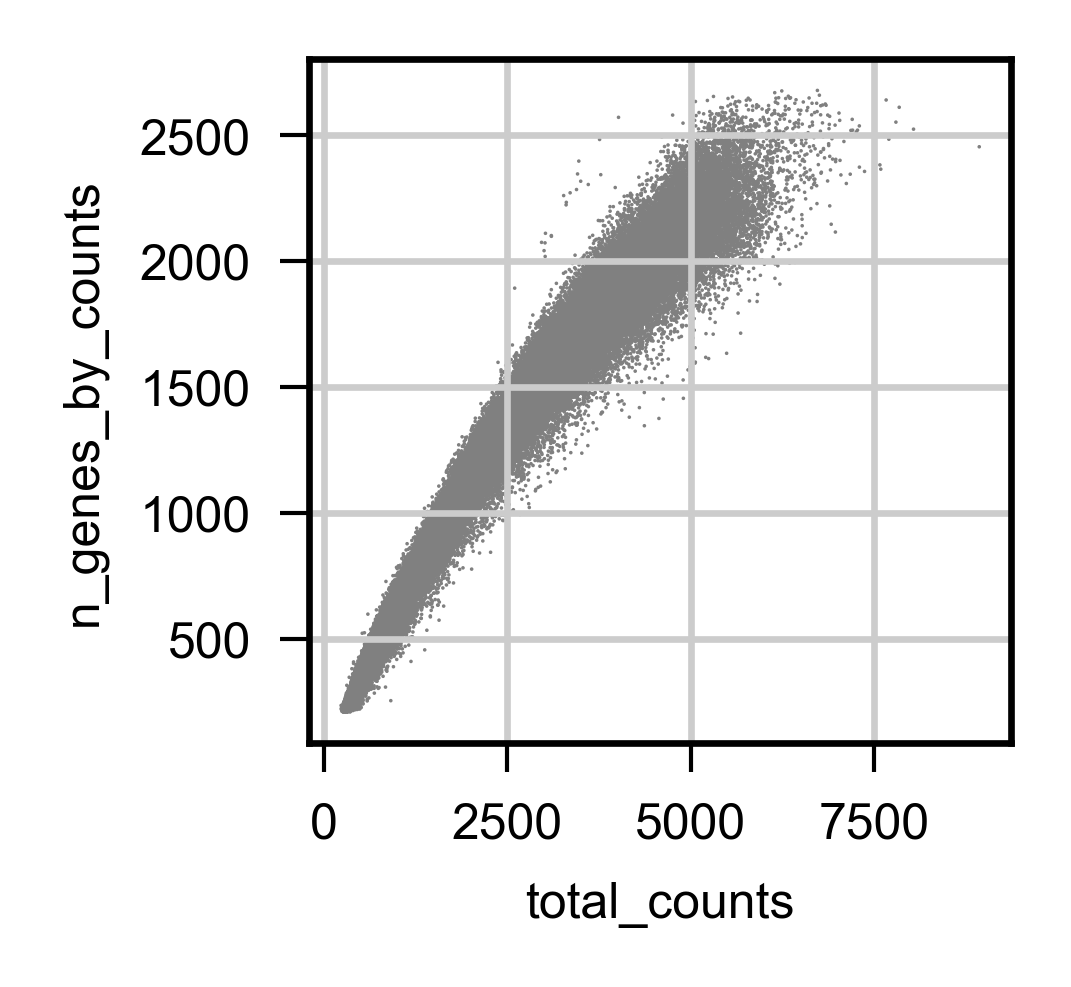

2023/09/21 02:30:11 PM  161006 cells remaining


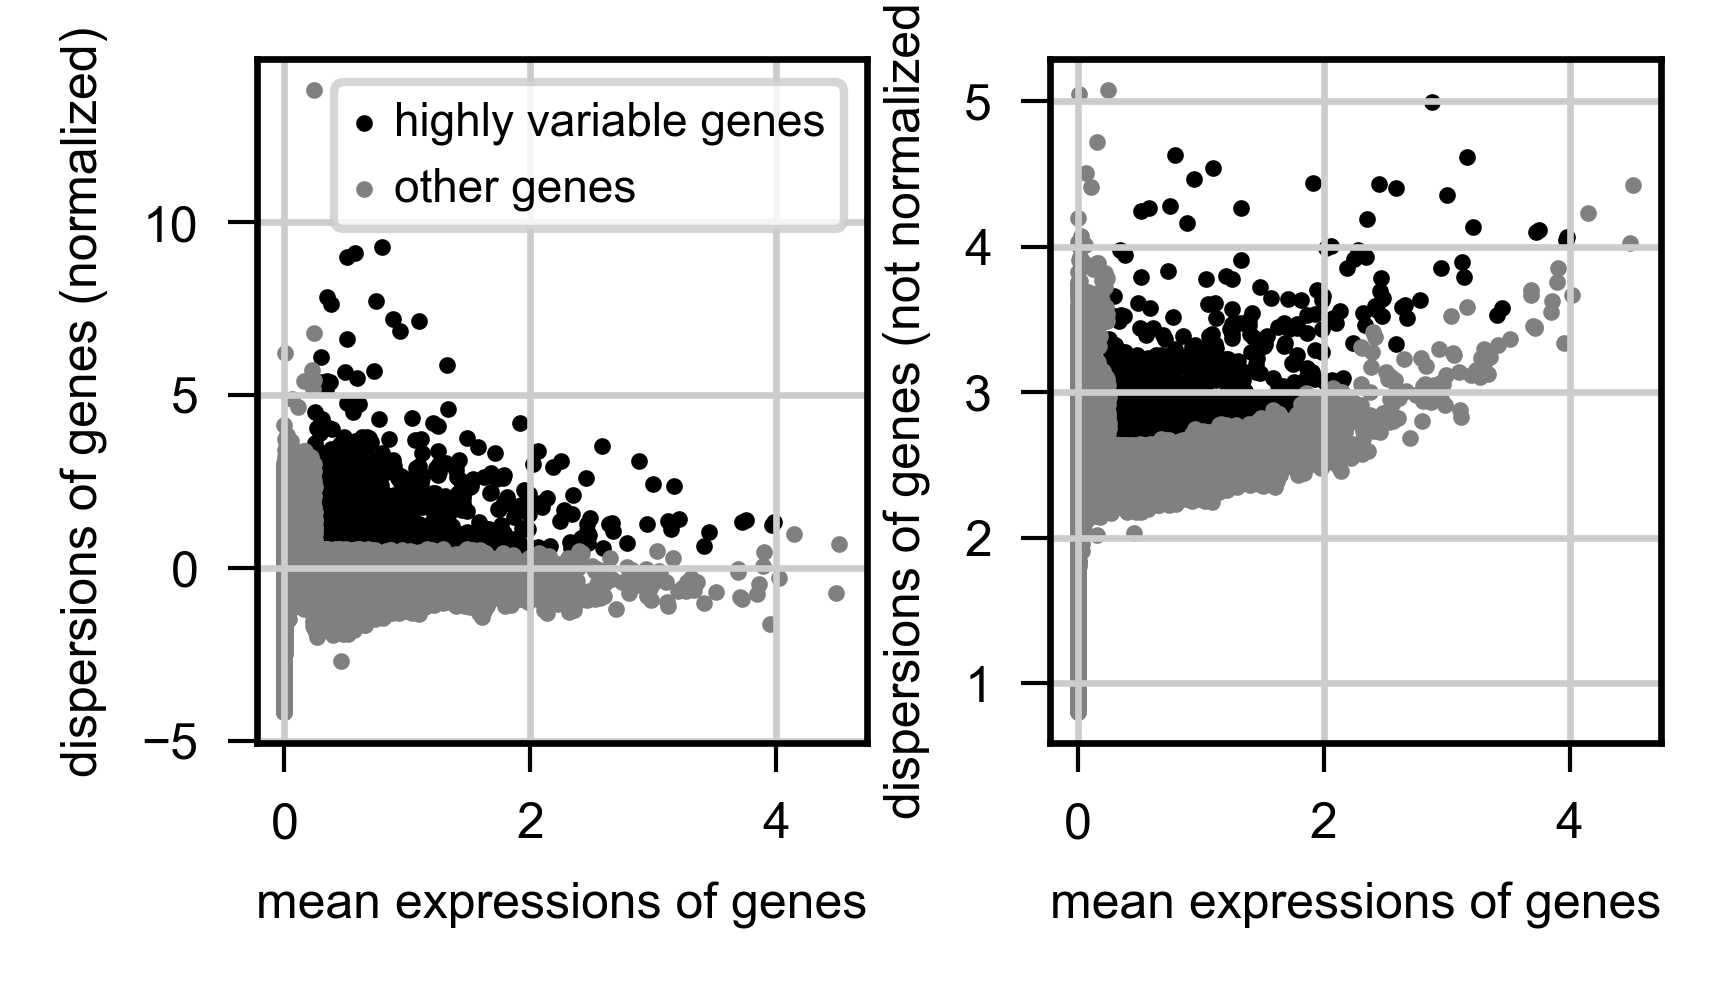

2023/09/21 02:30:17 PM  1043 hv genes
2023/09/21 02:30:33 PM  pulling gene annotations...
2023/09/21 02:30:33 PM  Use local copy of musmus
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,mt,coding,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
XKR4,False,True,49379,8.423643e-03,99.441879,74527.0
GM1992,False,False,3590,4.295066e-04,99.959423,3800.0
GM37381,False,False,3,3.390842e-07,99.999966,3.0
RP1,False,True,51,5.764432e-06,99.999424,51.0
RP1-1,False,False,0,0.000000e+00,100.000000,0.0


2023/09/21 02:31:15 PM  Filtering...
2023/09/21 02:31:15 PM  1605878 cells with >0.25% mt-RNA removed
2023/09/21 02:31:16 PM  27895 non coding genes removed
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To mak

<Figure size 450x450 with 0 Axes>

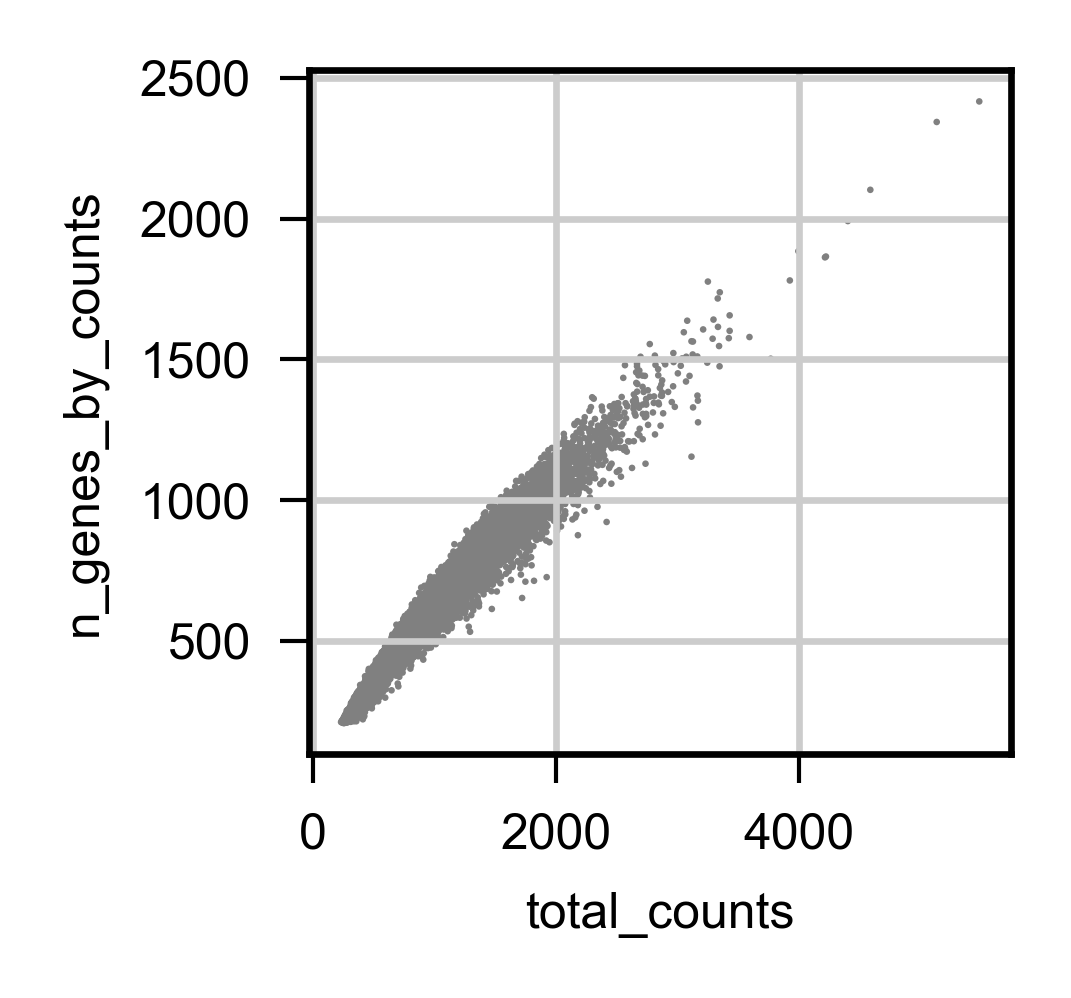

2023/09/21 02:31:18 PM  47599 cells remaining


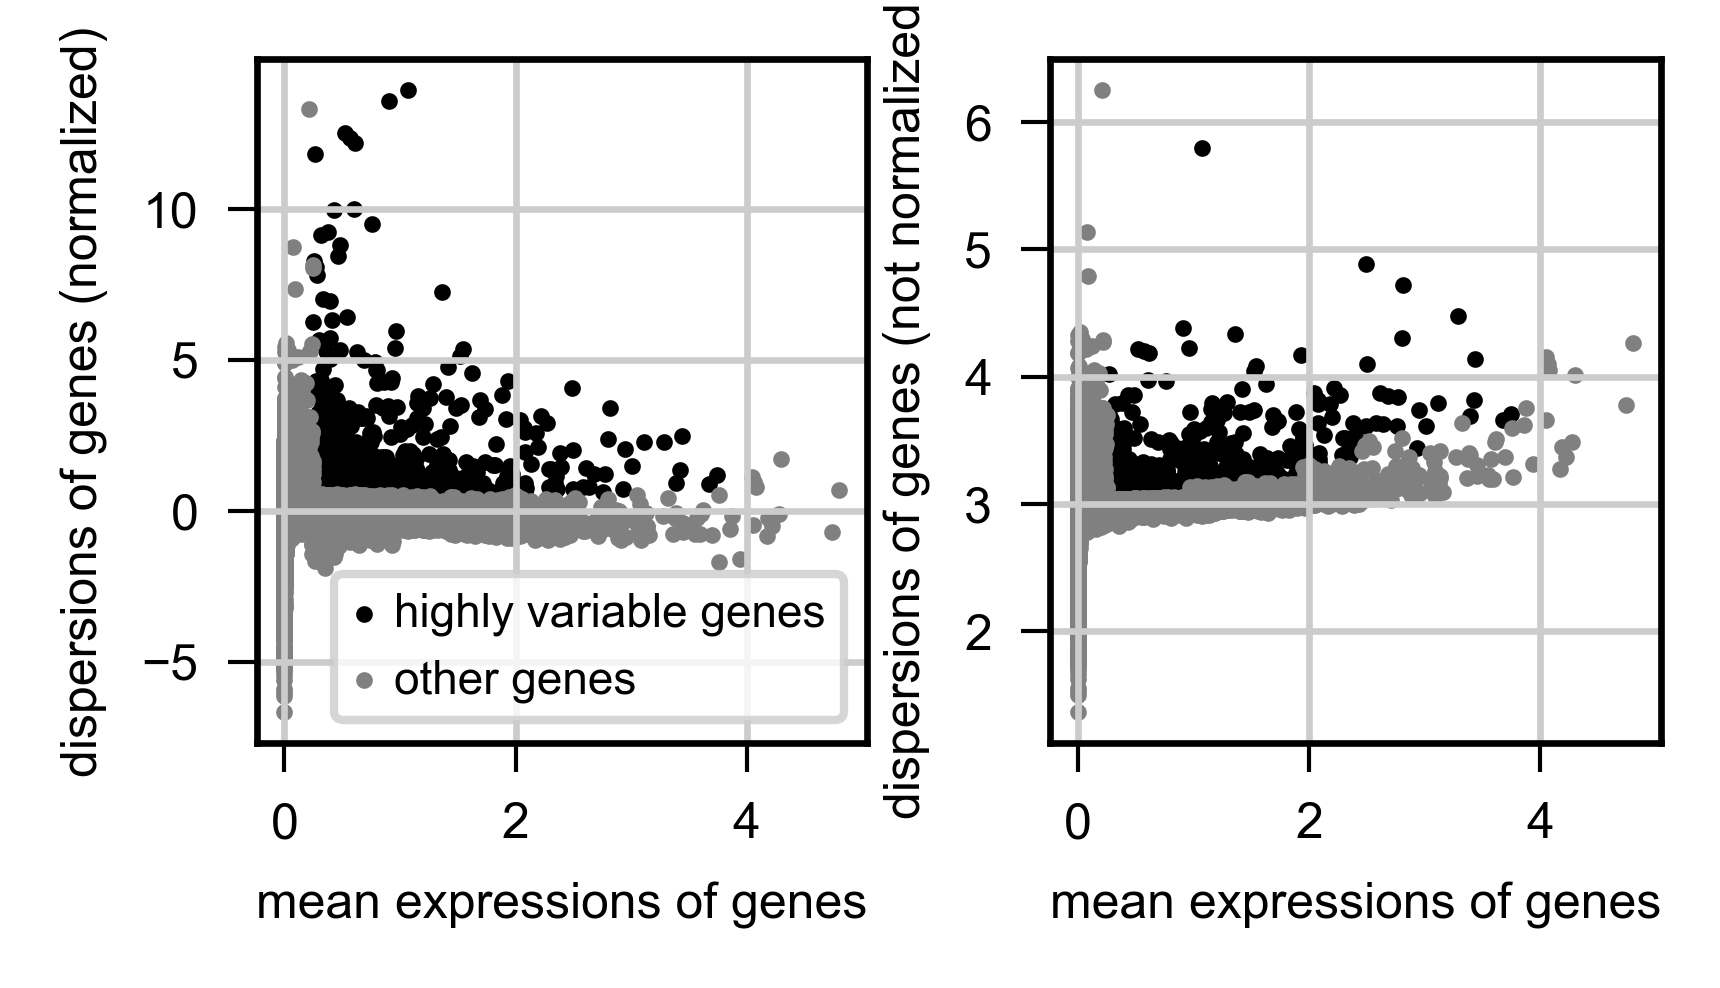

2023/09/21 02:31:19 PM  640 hv genes


<Figure size 450x450 with 0 Axes>

In [8]:
######### Reference Data Filter Dim Red #########
adata_zalo_filt = preprocess_andata10x(adata_zalo)[0]
adata_zalo_filt = high_var_genes_dim_reduc(adata_zalo_filt,min_mean = 0.25,max_mean = 4,min_disp=0.55)

######### Import Data Filter Dim Red #########
adata_ali_filt = preprocess_andata10x(adata_ali)[0]
adata_ali_filt = high_var_genes_dim_reduc(adata_ali_filt,min_mean = 0.25,max_mean = 4,min_disp=0.55)


In [9]:
adata_ali = []
adata_zalo = []

In [10]:

#### Parameter Match ####
adata_zalo_filt.obs['treatment'] = None

display(adata_zalo_filt.obs.head(2))
display(adata_ali_filt.obs.head(2))

display(adata_zalo_filt.var.head(2))
display(adata_ali_filt.var.head(2))




,age_bin,apoe_iso,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,n_counts,treatment
AAACCTGAGAATGTTG-1_GSM5106143,15m,E4,GSM5106143,2232,4801.0,1.0,0.020829,2011,3800.0,None
AAACCTGAGACTAAGT-1_GSM5106143,15m,E4,GSM5106143,2258,5933.0,1.0,0.016855,2052,4148.0,None


,sample,treatment,apoe_iso,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,n_counts
AAACCTGAGATAGGAG-1_01_E3Ki3611,01_E3Ki3611,BMX,E3Ki,700,1030.0,0.0,0.0,638,897.0
AAACCTGGTACGCACC-1_01_E3Ki3611,01_E3Ki3611,BMX,E3Ki,648,960.0,0.0,0.0,600,826.0


,mt,coding,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,not_mt,highly_variable,means,dispersions,dispersions_norm
Xkr4,False,True,312384,0.031242,98.675944,737090.0,True,False,2.566713,2.930504,-0.516370
Rp1,False,True,1303,0.000056,99.994477,1318.0,True,False,0.025776,2.433305,-0.176115


,mt,coding,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,not_mt,highly_variable,means,dispersions,dispersions_norm
XKR4,False,True,49379,0.008424,99.441879,74527.0,True,False,2.818439,3.168363,-0.488636
RP1,False,True,51,0.000006,99.999424,51.0,True,False,0.009167,2.928698,-0.269881


In [ ]:
adata_zalo_filt = umap_and_cluster(adata_zalo_filt, n_neighbors=35, n_pcs=25,resolution=.6,to_plot=False)
explore_umap(adata_zalo_filt,['Cluster (nn)','Sst','Pvalb'],legend_loc='on data',size=3)
explore_umap(adata_zalo_filt,['Cluster (nn)','Gad1','Gad2'],legend_loc='on data',size=3)
explore_umap(adata_zalo_filt,['Cluster (nn)','Vip','Reln'],legend_loc='on data',size=3)
explore_umap(adata_zalo_filt,['Cluster (nn)','Syn1','Slc1a3'],legend_loc='on data',size=3)


# sc.pp.pca(adata_zalo)
# sc.pp.neighbors(adata_zalo)
# sc.tl.umap(adata_zalo)

# sc.tl.ingest(adata, adata_ref, obs='louvain')

In [ ]:

def high_var_genes_dim_reduc(adata,min_mean = 0.25,max_mean = 4,min_disp=0.55,pca_list=[],to_plot=True):
    ''' The gene expression matrices were then log-normalized with a scale factor of 10,000,
    using the Seurat NormalizeData function57,58. Highly dispersed genes were selected using
    the Seurat FindVariableGenes function57,58,filtering for an average expression range of
    0.25–4 and a minimum dispersion of 0.55, resulting in a list of 2,197 genes.'''
    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=10000)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
    with rc_context({'figure.figsize': (1.5, 1.5)}):
        sc.pl.highly_variable_genes(adata)
    plt.tight_layout()
    num_hv =  str(np.sum(adata.var['highly_variable']))
    logging.info(f'{num_hv} hv genes')


    #### PCA
    sc.tl.pca(adata, svd_solver='arpack',n_comps=100)
    if to_plot and len(pca_list)>0:
        fig,ax=plt.subplots(figsize=(1.5,1))
        ax.plot(adata.uns['pca']['variance_ratio'][:35],'ok',markersize=1)
        quiet_PCA_plots(adata,pca_list,pc_pairs=[(0,1),(2,3),(4,5),(6,7)])

    return adata

def quiet_PCA_plots(adata,key_list,figsize=(1.5, 1.5),pc_pairs=[(0,1)]):
    fig,ax=plt.subplots(1*len(pc_pairs),len(key_list),figsize=(figsize[0]*len(key_list),figsize[1]*len(pc_pairs)))
    for ip,pair in enumerate(pc_pairs):
        if len(key_list) == 1: ax=[ax]
        for key_ind,key in enumerate(key_list):
            key_types = sorted(list(set( adata.obs[key] )))
            for k in key_types:
                is_k = adata.obs[key]==k
                ax[ip,key_ind].scatter(adata.obsm['X_pca'][is_k,pair[0]],adata.obsm['X_pca'][is_k,pair[1]],s=2,marker='.',linewidth=0,edgecolors=None,label=k)
                ax[ip,key_ind].set_xlabel(f'PC{pair[0]}')
                ax[ip,key_ind].set_ylabel(f'PC{pair[1]}')
            if len(key_types)<8: ax[ip,key_ind].legend(key_types,loc='best',markerscale=3)
            ax[ip,key_ind].set_title(key)
            plt.tight_layout()
    return None



In [ ]:
# adata_filt = umap_and_cluster(adata_filt, n_neighbors=35, n_pcs=25,resolution=.6,to_plot=False)
# explore_umap(adata_filt,['Cluster (nn)','SST','PVALB'],legend_loc='on data',size=3)
# explore_umap(adata_filt,['Cluster (nn)','GAD1','GAD2'],legend_loc='on data',size=3)
# explore_umap(adata_filt,['Cluster (nn)','VIP','RELN'],legend_loc='on data',size=3)
# explore_umap(adata_filt,['Cluster (nn)','SYN1','SLC1A3'],legend_loc='on data',size=3)

In [ ]:
# ############## GABAERGIC Filter #####################
# adata_GABA = adata_filt.copy()
# adata_GABA.obs['Gad1_pos'] = z_score(sc.get.obs_df(adata_GABA,'Gad1'))>0.0
# adata_GABA.obs['Gad2_pos'] = z_score(sc.get.obs_df(adata_GABA,'Gad2'))>0.0
# adata_GABA.obs['Syn1_pos'] = z_score(sc.get.obs_df(adata_GABA,'Syn1'))>-100
# is_gaba = np.logical_and( np.logical_or(adata_GABA.obs['Gad1_pos'] , adata_GABA.obs['Gad2_pos'] ), adata_GABA.obs['Syn1_pos'])
# adata_GABA.obs['Gabaergic'] = is_gaba
# adata_GABA = adata_GABA[ adata_GABA.obs['Gabaergic'] ,:]



# adata_GABA = umap_and_cluster(adata_GABA, n_neighbors=5, n_pcs=25,resolution=.6,to_plot=False)
# explore_umap(adata_GABA,['Cluster (nn)','Sst','Pvalb'],legend_loc='on data',size=8)
# # explore_umap(adata_GABA,['sample','treatment','apoe_iso'],size=8)
# # explore_umap(adata_GABA,[],size=8)
